<a href="https://colab.research.google.com/github/iwataka0715/practice/blob/main/%E6%9D%B1%E4%BA%AC%E3%82%B7%E3%82%B9%E3%83%86%E3%83%A0%E6%8A%80%E7%A0%94demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install gdown

In [5]:
!gdown --id 1iuDqJ5QewZ0J26eCfJk3-Xbp1nnjKm3o

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1iuDqJ5QewZ0J26eCfJk3-Xbp1nnjKm3o
From (redirected): https://drive.google.com/uc?id=1iuDqJ5QewZ0J26eCfJk3-Xbp1nnjKm3o&confirm=t&uuid=b716f4d3-858d-4525-b589-cd53a603ee55
To: /content/train.zip
100% 98.7M/98.7M [00:01<00:00, 77.2MB/s]


In [6]:
# ファイルを解凍
!unzip /content/train.zip > /dev/null

In [7]:
# ライブラリのインポート(globライブラリを用いてファイル検索)
import glob

# ファイル一覧を取得
images = glob.glob('/content/train/*.jpg')

# ファイル名を確認(先頭3枚)
print(images[:3])

['/content/train/cat.455.jpg', '/content/train/cat.137.jpg', '/content/train/dog.1291.jpg']


filename:/content/train/cat.455.jpg, size:(499, 375)


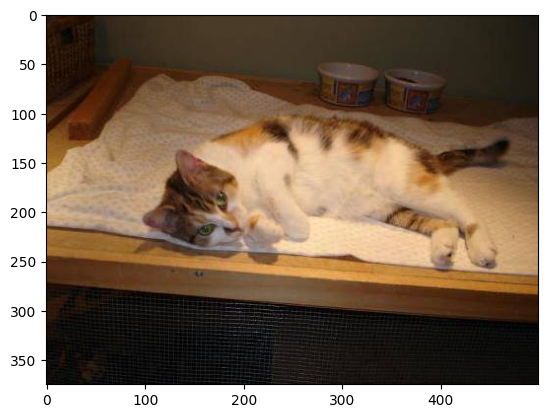

In [8]:
# 画像表示に必要なモジュールをインポート
import matplotlib.pyplot as plt
from PIL import Image

# 画像の表示
image_sample = images[0]
img = Image.open(image_sample)
print('filename:{}, size:{}'.format(image_sample, img.size))
plt.imshow(img)
plt.show()

画像データの分割

In [9]:
import os

# train用フォルダ作成
os.makedirs('/content/images/train/dog', exist_ok=True)
os.makedirs('/content/images/train/cat', exist_ok=True)

# val用フォルダ作成
os.makedirs('/content/images/val/dog', exist_ok=True)
os.makedirs('/content/images/val/cat', exist_ok=True)

# test用フォルダ作成
os.makedirs('/content/images/test/dog', exist_ok=True)
os.makedirs('/content/images/test/cat', exist_ok=True)

In [10]:
# 犬・猫ごとのファイルパス一覧を取得
images_dog = glob.glob('/content/train/dog.*.jpg')
images_cat = glob.glob('/content/train/cat.*.jpg')

In [11]:
# ファイルを分割(train, val, test)
idx_test_start = int(len(images_cat) * 0.8)
idx_val_start = int(idx_test_start * 0.8)

images_train_dog = images_dog[:idx_val_start]
images_train_cat = images_cat[:idx_val_start]

images_val_dog = images_dog[idx_val_start:idx_test_start]
images_val_cat = images_cat[idx_val_start:idx_test_start]

images_test_dog = images_dog[idx_test_start:]
images_test_cat = images_cat[idx_test_start:]

In [12]:
import shutil

# 一括でファイルを移動する関数を作成
def move_files(file_list, target_dir):
    for file in file_list:
        shutil.move(file, target_dir)

# ファイル移動
move_files(images_train_dog, '/content/images/train/dog/')
move_files(images_train_cat, '/content/images/train/cat/')
move_files(images_val_dog, '/content/images/val/dog/')
move_files(images_val_cat, '/content/images/val/cat/')
move_files(images_test_dog, '/content/images/test/dog/')
move_files(images_test_cat, '/content/images/test/cat/')

# 学習の準備

## 学習条件の設定

In [24]:
#分類するクラス
classes = ['cat', 'dog']
nb_classes = len(classes)

# データのディレクトリ
train_data_dir = '/content/images/train'
validation_data_dir = '/content/images/val'
test_data_dir = '/content/images/test'

# 学習回数
epochs = 10

# バッチサイズ
batch_size = 16

# 画像サイズ
img_width, img_height = 224, 224

## ImageDataGeneratorの作成

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 学習データのImageDataGenerator作成
train_datagen = ImageDataGenerator(rescale=1.0 / 255)  # rescaleで各画素のスケールを0～255から0～1に変換
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1920 images belonging to 2 classes.


In [15]:
# 検証データのImageDataGenerator作成
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = validation_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size
)

Found 480 images belonging to 2 classes.


In [16]:
# 評価データのImageDataGenerator作成
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    shuffle=False  # シャッフルしない
)

Found 600 images belonging to 2 classes.


# 学習

## 学習済みモデル(VGG16)

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense

input_tensor = Input(shape=(img_width, img_height, 3))
VGG16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

## モデルの作成

In [26]:
# VGG16のパラメータを凍結(すべての層を凍結)
for layer in VGG16.layers:
    layer.trainable = False

In [30]:
# 差し替え用の新しい層を追加
# model = Sequential()
# model.add(VGG16)
x = Flatten()(VGG16.output) # Add the flatten layer to the output of vgg16
x = Dense(nb_classes, activation='softmax')(x) # Add the Dense layer to the output of the flatten layer

model = Model(inputs=input_tensor, outputs=x) # Create a functional model

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │          50,178 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

## 学習の実行

In [33]:
# 学習
steps_per_epoch = int(len(train_generator.classes) / batch_size)
history = model.fit(
    x=train_generator,  # 学習データ
    steps_per_epoch=steps_per_epoch,  # ステップ数
    epochs=epochs,  # エポック数
    validation_data=validation_generator  # 検証データ
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.7153 - loss: 0.8013 - val_accuracy: 0.8729 - val_loss: 0.3167
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8729 - val_loss: 0.3167
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9502 - loss: 0.1208 - val_accuracy: 0.8729 - val_loss: 0.2485
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8729 - val_loss: 0.2485
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.9786 - loss: 0.0674 - val_accuracy: 0.9229 - val_loss: 0.2271
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9229 - val_loss: 0.2271
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9954 - loss: 0.0316 - val_accuracy: 0.9229 - val_loss: 0.1923
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9229 - val_loss: 0.1923
Epoch 9/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 1.0000 

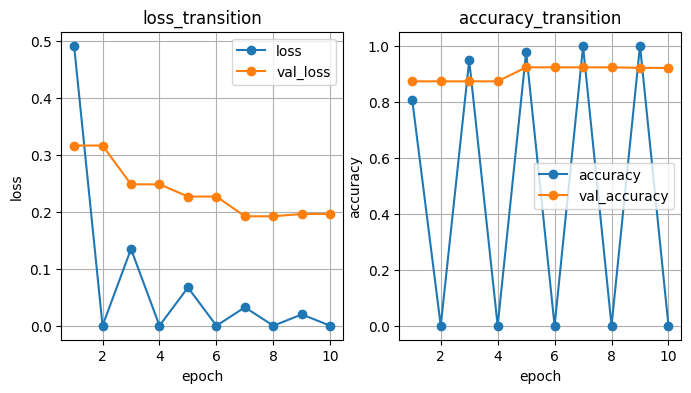

In [34]:
# グラフ描画(2画面)
plt.figure(figsize=(8, 4))

# epochごとのlossを表示
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history.history['loss'], '-o')
plt.plot(range(1, epochs+1), history.history['val_loss'], '-o')
plt.title('loss_transition')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='best')

# epochごとのaccuracyを表示
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history.history['accuracy'], '-o')
plt.plot(range(1, epochs+1), history.history['val_accuracy'], '-o')
plt.title('accuracy_transition')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='best')

# グラフ表示
plt.show()

# 評価

## 評価データでの予測

In [35]:
model.evaluate(test_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 757ms/step - accuracy: 0.9161 - loss: 0.2092


[0.2054593861103058, 0.9166666865348816]

## 混同行列

In [36]:
# 正解のラベル一覧を作成。
true = test_generator.classes
true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [37]:
# 予測のラベル一覧を作成
import numpy as np
p = model.predict(test_generator)
pred = np.argmax(p, axis=1)
pred

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,

In [38]:
# 混同行列表示
from tensorflow.math import confusion_matrix
confusion_matrix(true, pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[274,  26],
       [ 24, 276]], dtype=int32)>